# Классификация одежды с помощью K-ближайших соседей (KNN)

## Этап 1: Загрузка и исследование данных

Познакомимся с изображениями, которые мы будем классифицировать.
Загружаем датасет Fashion MNIST и смотрим, как выглядят изображения.



In [18]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_train и X_test — изображения.

y_train и y_test — номера классов (от 0 до 9).

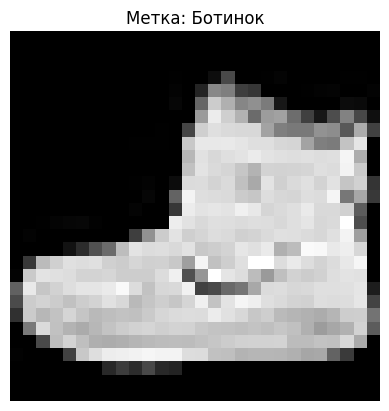

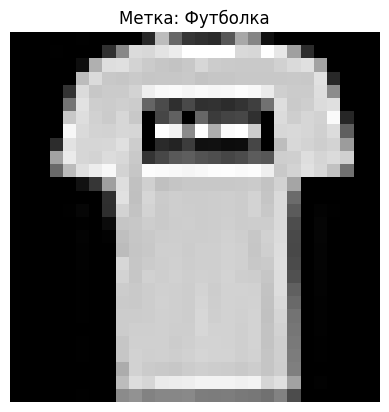

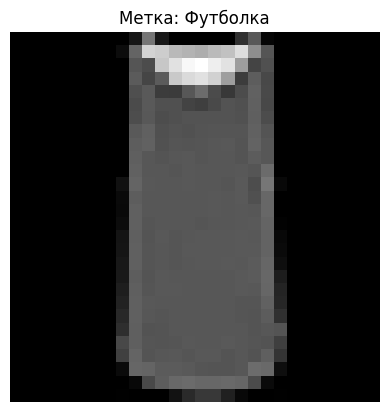

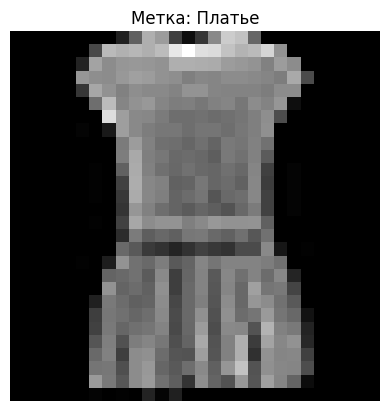

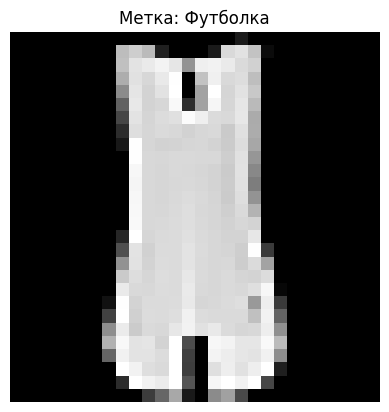

In [19]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

class_names = ['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто',
               'Сандалия', 'Рубашка', 'Кроссовки', 'Сумка', 'Ботинок']

for i in range(5):
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Метка: {class_names[y_train[i]]}")
    plt.axis('off')
    plt.show()

### Визуализация

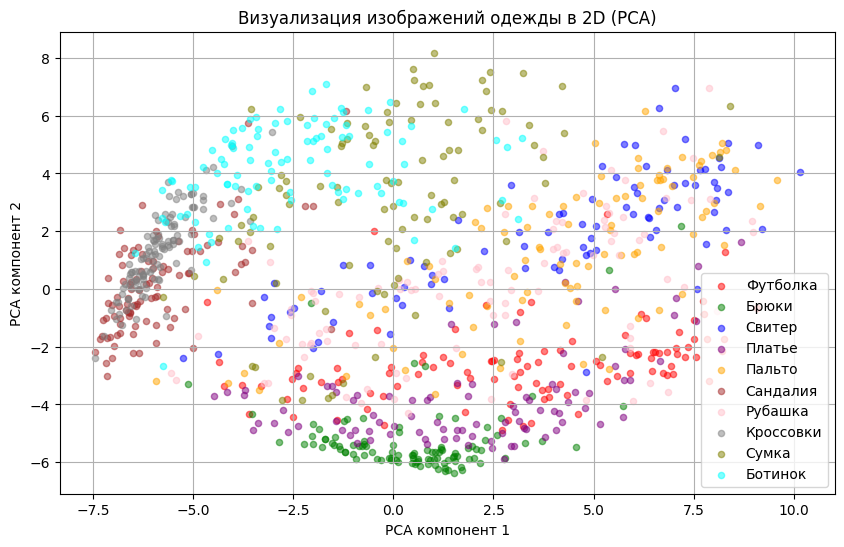

In [20]:
# Подготовка данных
X_train_flat = X_train.reshape(-1, 28 * 28) / 255.0

# Уменьшим выборку для скорости визуализации
num_samples = 1000
X_subset = X_train_flat[:num_samples]
y_subset = y_train[:num_samples]

# PCA: уменьшаем до 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_subset)

# Цвета для 10 классов
colors = ['red', 'green', 'blue', 'purple', 'orange',
          'brown', 'pink', 'gray', 'olive', 'cyan']

# Визуализация в 2D
plt.figure(figsize=(10, 6))
for i in range(10):
    idx = y_subset == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1],
                color=colors[i],
                label=class_names[i],
                alpha=0.5,
                s=20)

plt.legend()
plt.title('Визуализация изображений одежды в 2D (PCA)')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.grid(True)
plt.show()


## Этап 2: Подготовка данных

Теперь нам нужно привести изображения к нужному формату для обучения модели.
Что делаем: разворачиваем каждое изображение в вектор и нормализуем значения пикселей.

In [21]:
# Преобразуем 28x28 изображения в векторы длины 784 и делим на 255
X_train_flat = X_train.reshape(-1, 28 * 28) / 255.0
X_test_flat = X_test.reshape(-1, 28 * 28) / 255.0 #то же самое для тестовой выборки

reshape(-1, 28*28) превращает каждое 2D-изображение в 1D-вектор.

/255.0 нормализует значения пикселей (они будут от 0 до 1).

##  Этап 3: Обучение модели KNN

In [22]:
import numpy as np
from collections import Counter

Теперь нам нужно обучить модель распознавать фотографии. Для этого создаем модель KNN и "обучаем" её.

In [23]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [24]:
def knn_predict(X_train, y_train, x_test, k=3):
    distances = []
    for i in range(len(X_train)):
        dist = euclidean_distance(X_train[i], x_test)
        distances.append((dist, y_train[i]))

    # Сортируем по расстоянию и берём k ближайших
    distances.sort(key=lambda x: x[0])
    k_neighbors = [label for _, label in distances[:k]]

    # Находим самый частый класс
    most_common = Counter(k_neighbors).most_common(1)
    return most_common[0][0]

Алгоритм KNN не "обучается" в классическом смысле — он просто запоминает примеры.

При предсказании он ищет ближайшие изображения в памяти.

## Этап 4: Классификация и предсказание

Найдём оптимально число соседейс помощью кросс-валидации k-fold.

In [25]:
import matplotlib.pyplot as plt

In [26]:
# Используем уменьшенные выборки
X_train_small = X_train_flat[:300]
y_train_small = y_train[:300]
X_test_small = X_test_flat[:100]
y_test_small = y_test[:100]

# Проверим несколько значений k
k_values = list(range(1, 16))
accuracies = []

for k in k_values:
    correct = 0
    for i in range(len(X_test_small)):
        pred = knn_predict(X_train_small, y_train_small, X_test_small[i], k=k)
        if pred == y_test_small[i]:
            correct += 1
    accuracy = correct / len(X_test_small)
    accuracies.append(accuracy)
    print(f"k = {k}: точность = {accuracy * 100:.2f}%")


k = 1: точность = 69.00%
k = 2: точность = 69.00%
k = 3: точность = 70.00%
k = 4: точность = 72.00%
k = 5: точность = 70.00%
k = 6: точность = 71.00%
k = 7: точность = 70.00%
k = 8: точность = 70.00%
k = 9: точность = 68.00%
k = 10: точность = 68.00%
k = 11: точность = 68.00%
k = 12: точность = 69.00%
k = 13: точность = 70.00%
k = 14: точность = 71.00%
k = 15: точность = 70.00%


In [27]:
best_k_index = np.argmax(accuracies)
best_k = k_values[best_k_index]
print(f"Лучшее значение k: {best_k} (точность = {accuracies[best_k_index] * 100:.2f}%)")

Лучшее значение k: 4 (точность = 72.00%)


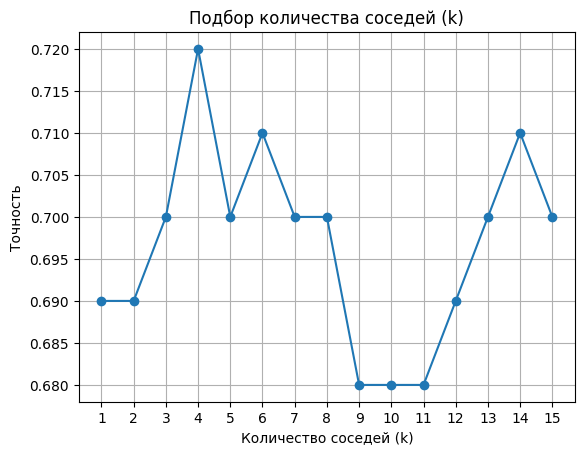

In [28]:
plt.plot(k_values, accuracies, marker='o')
plt.title('Подбор количества соседей (k)')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.xticks(k_values)
plt.grid(True)
plt.show()

Сделаем предсказания модели и проверим, насколько они точны.

In [29]:
# Предсказываем метки для 100 тестовых примеров
y_pred = []
for i in range(100):
    pred = knn_predict(X_train_flat, y_train, X_test_flat[i], best_k)
    y_pred.append(pred)

## Этап 5: Оценка точности

Убедимся, насколько хорошо работает модель.

In [30]:
from sklearn.metrics import accuracy_score, classification_report

In [31]:
# Сравниваем предсказания и настоящие метки
correct = 0
for i in range(100):
    if y_pred[i] == y_test[i]:
        correct += 1

accuracy = correct / 100
print(f"Точность на первых 100 изображениях: {accuracy * 100:.2f}%")


Точность на первых 100 изображениях: 86.00%


## Этап 6: Визуализация результатов

Посмотрим на примеры, где модель угадала и не угадала.



In [32]:
import numpy as np

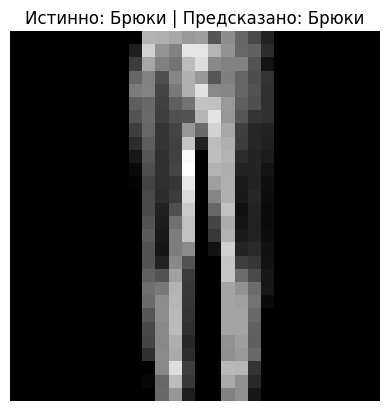

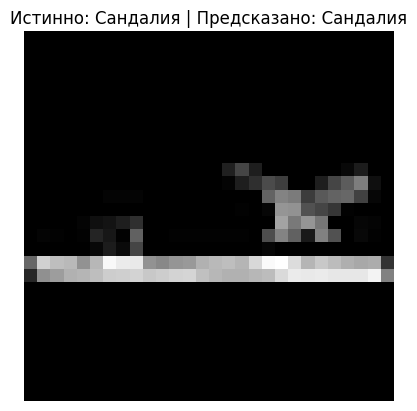

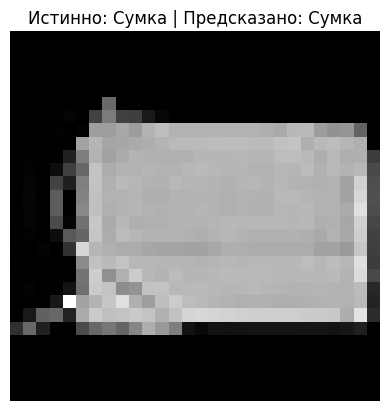

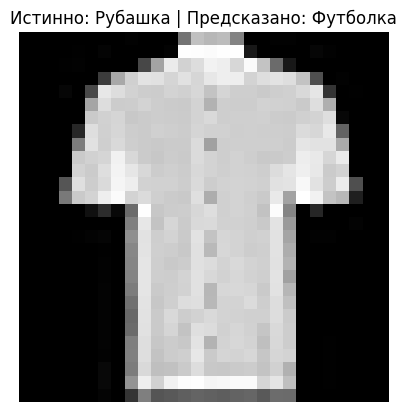

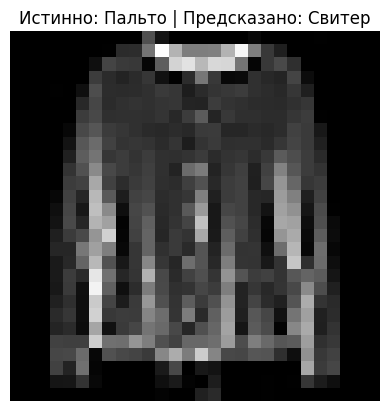

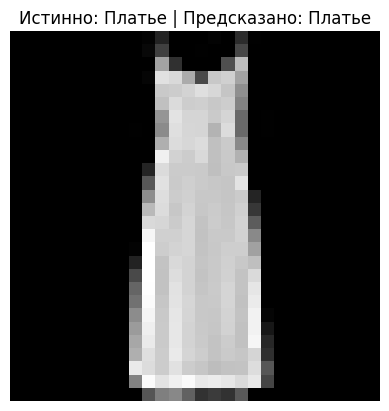

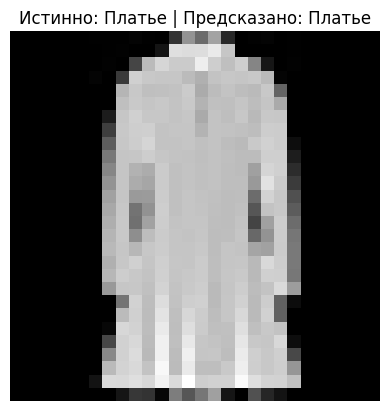

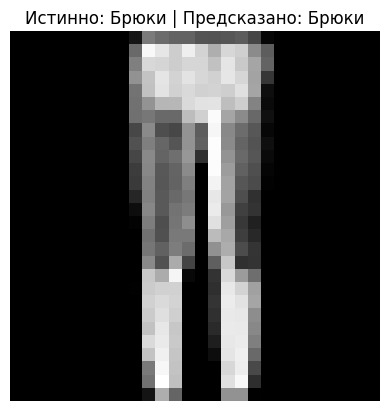

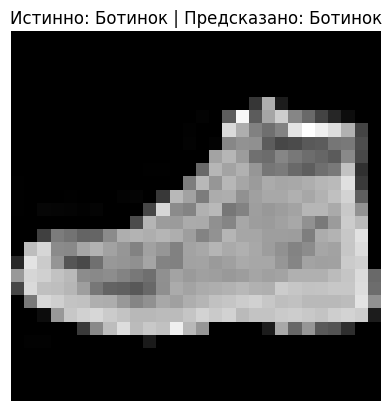

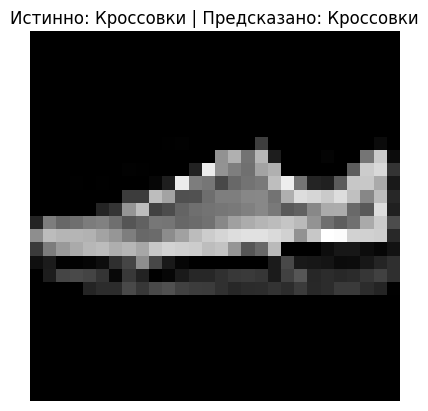

In [34]:
for i in np.random.choice(100, 10, replace=False):
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"Истинно: {class_names[y_test[i]]} | Предсказано: {class_names[y_pred[i]]}")
    plt.axis('off')
    plt.show()

Это помогает "глазами" оценить, насколько модель делает разумные предсказания.

Особенно полезно увидеть ошибки и подумать, почему модель могла спутать одежду.